Keras LSTM Classifier
--
This article describes how the Keras LSTM network can be used to classify sentences based on their content. We begin by importing the training and testing datasets and decoding the content to python variables.

In [1]:

(X_train0, y_train), (X_test0, y_test) = super_secret_dataset.load_data(nobelow=3)

Using TensorFlow backend.
........
10 .........
100 .........
1000 .........
10000 ....
Filtering words
........
10 .........
100 .........
1000 ....
UNK 21160


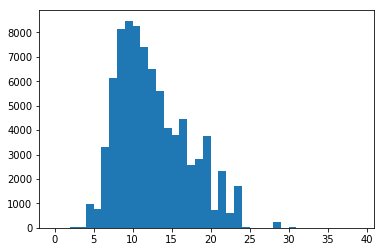

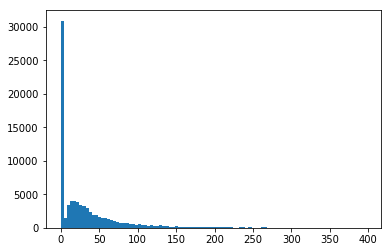

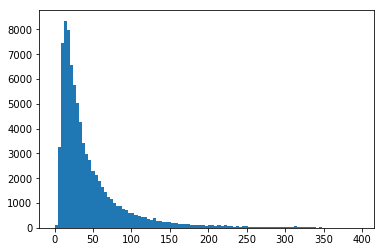

In [2]:
import numpy as np


Using the keras model
--
We use the keras library similarily to this [tutorial](https://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/). Here we've written a library component to process the data to the same format as the imdb dataset that is included in the keras library.

In [3]:
from collections import Counter
from itertools import chain
#Count our dictionary length
wordcount = len(Counter(chain.from_iterable([x[0]+x[1]+x[2] for x in X_train0]))) + 2
max(Counter(chain.from_iterable([x[0]+x[1]+x[2] for x in X_train0]))), wordcount

(27946, 27949)

In [4]:
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras import backend as K
from keras import regularizers
from keras_evaluation import precision, recall

def get_model(top_words, embedding_vector_length=32, max_review_length=150, lstm=(170,), useconv=1):
    # create the model
    model = Sequential()
    model.add(Embedding(top_words, embedding_vector_length, input_length=max_review_length))
    if useconv:
        model.add(Conv1D(filters=embedding_vector_length, kernel_size=3, padding='same', activation='relu'))
        model.add(MaxPooling1D(pool_size=2))
    for i in lstm[:-1]:
        model.add(LSTM(i, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
    model.add(LSTM(lstm[-1], dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(1, activation='sigmoid',
                    kernel_regularizer=regularizers.l2(0.001),
                    activity_regularizer=regularizers.l1(0.001)))
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    #print(model.summary())
    return model

In [6]:
max_review_length=700

In [7]:
def concat2(X_train, limit=100):
    padding1 = wordcount - 1
    padding2 = wordcount - 2
    for x in X_train:
        yield x[0][:limit] + [padding1] + x[1][:limit] + [padding2] + x[2]

X_train = sequence.pad_sequences(list(concat2(X_train0, 200)),
                                 maxlen=max_review_length,
                                 truncating='post')
X_test = sequence.pad_sequences(list(concat2(X_test0, 200)),
                                maxlen=max_review_length,
                                truncating='post')

In [8]:
from keras.models import load_model
def save_model(model, modelpath):
    model.save(modelpath)
    
def model_deep_copy(model):
    modelpath = "/tmp/model.h5"
    save_model(model, modelpath)
    return load_model(modelpath)

In [ ]:
from matplotlib.animation import FuncAnimation
import keras_evaluation
import sys
evaluate_model = keras_evaluation.evaluate_model
roc_auc = keras_evaluation.roc_auc

import seaborn
import itertools
from matplotlib import rc
from matplotlib import pyplot as plt
rc('animation', html='html5')

lstm_layers = (160,80,2)

model = get_model(wordcount, max_review_length=max_review_length, lstm=lstm_layers, useconv=0)
modelb = model_deep_copy(model)

besti = 0
#aucroc = evaluate_model(model, X_test, y_test)
aucroc, fpr, tpr = roc_auc(modelb, X_test, y_test)
#aucroc = 0.5

X_train_c = itertools.cycle(X_train)
y_train_c = itertools.cycle(y_train)

fig, ax = plt.subplots()
xdata, ydata = fpr, tpr
ln, = plt.plot(xdata, ydata, animated=True)
aucrocs = []

def update(i):
    modelb.fit(np.array(list(itertools.islice(X_train_c, 1024))),
               np.array(list(itertools.islice(y_train_c, 1024))),
               epochs=1, batch_size=64, verbose=0)
    aucrocb, fpr, tpr = roc_auc(modelb, X_test, y_test)
    xdata, ydata = fpr, tpr
    ln.set_data(xdata, ydata)
    aucrocs.append(aucrocb)
    sys.stderr.write(".")
    #if aucrocb > aucroc:
    #    sys.stderr.write("\nB is better!\n")
    #    model = model_deep_copy(modelb)
    #    aucroc = aucrocb
    #    besti = (1 + i)*1000
    return ln,
        

anim = FuncAnimation(fig, update, frames=np.arange(0, 100), interval=100)
anim


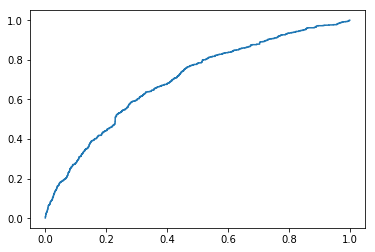

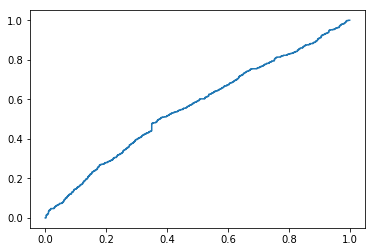

.

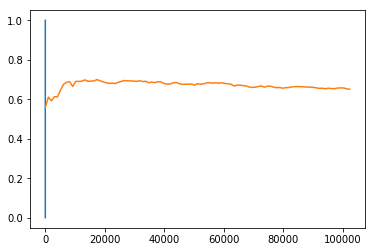

In [18]:
from matplotlib import pyplot as plt
plt.plot(np.arange(0, len(aucrocs)*1024, 1024), np.array(aucrocs))
plt.show()

In [ ]:
max_review_length=700
model = get_model(wordcount, max_review_length=max_review_length, lstm=lstm_layers, useconv=1)
besti = 0
#aucroc = evaluate_model(model, X_test, y_test)
aucroc, fpr, tpr = evaluate_model(modelb, X_test, y_test)
#aucroc = 0.5

X_train_c = itertools.cycle(X_train)
y_train_c = itertools.cycle(y_train)

fig, ax = plt.subplots()
xdata, ydata = fpr, tpr
ln, = plt.plot(xdata, ydata, animated=True)
aucrocs = []

def update(i):
    modelb.fit(np.array(list(itertools.islice(X_train_c, 1024))),
               np.array(list(itertools.islice(y_train_c, 1024))), epochs=1, batch_size=64)
    aucrocb, fpr, tpr = evaluate_model(modelb, X_test, y_test)
    xdata, ydata = fpr, tpr
    ln.set_data(xdata, ydata)
    aucrocs.append(aucrocb)
    #if aucrocb > aucroc:
    #    print("B is better!")
    #    model = model_deep_copy(modelb)
    #    aucroc = aucrocb
    #    besti = (1 + i)*1000
    return ln,
        

anim2 = FuncAnimation(fig, update, frames=np.arange(0, 100), interval=100)
anim2
